# PHONEME DRIVEN SPEECH TO TEXT MODEL   

# Word Pronunciations: Word to Phoneme Conversion

A phoneme is a sound or a group of different sounds perceived to have the same function by speakers of the language or dialect in question. An example is the English phoneme /k/, which occurs in words such as cat, kit, scat, skit.

<div class='alert alert-info'><strong>Phoneme Conversion:</strong> Converts lexical orthographic symbols (words) to phonetic representation along with other possible information such as stress placement.</div>


__Phoneme Conversion__
- Words to phonemes converters can help you figure out how to pronounce a certain word. e.g. Google word pronunication utility
- Conversion of words to phonemes is an important step in the process of Speech-To-Text synthesis, where a system is given an input text which is preprocessed through various stages to identify how a text sentence needs to be spoken out loud by identifying the pronunciations and prosody of each word present in the sentence.


In [1]:
import pandas as pd
import numpy as np

# Model Related Libraries
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split

# Viz Libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries used for Audio Data
import librosa
import librosa.display

# Viz Params
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 16
sns.set_style('darkgrid')

In [2]:
!pip install datasets -q
from datasets import load_dataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 33.8 MB/s eta 0:00:00


Dataset is on Kaggle so using the API to get the data.

In [3]:
# Install the kaggle library
!pip install -q kaggle

# Upload the Kaggle API keys
from google.colab import files
files.upload()

!mkdir ~/.kaggle

# Copy the json file to the folder
!cp kaggle.json ~/.kaggle

# Change permissions for keys to work with the Kaggle API
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d rtatman/cmu-pronouncing-dictionary

# Unzipping the dataset
! unzip /content/cmu-pronouncing-dictionary.zip

Saving kaggle.json to kaggle.json
100% 904k/904k [00:00<00:00, 1.38MB/s]
100% 904k/904k [00:00<00:00, 1.38MB/s]
Archive:  /content/cmu-pronouncing-dictionary.zip
  inflating: LICENSE.txt             
  inflating: cmudict.dict            
  inflating: cmudict.phones          
  inflating: cmudict.symbols         
  inflating: cmudict.vp              


# Word To Phoneme

In [19]:
words = []
phonics_list = []
dict_file = open('/content/cmudict.dict', 'r')
with dict_file as f:
    phonics = [line.rstrip('\n') for line in f]
    for p in phonics:
        x = p.split(' ')
        words.append(x[0])
        phonics_list.append(' '.join(x[1:]))
data = pd.DataFrame({'Word': words, 'Phonics': phonics_list})
data.head()

,Word,Phonics
0,'bout,B AW1 T
1,'cause,K AH0 Z
2,'course,K AO1 R S
3,'cuse,K Y UW1 Z
4,'em,AH0 M


In [20]:
df = data.sample(100000).reset_index(drop=True)
df

,Word,Phonics
0,vastola,V AA0 S T OW1 L AH0
1,homestake's,HH OW1 M S T EY2 K S
2,trax,T R AE1 K S
3,disrupted,D IH0 S R AH1 P T IH0 D
4,bakke,B AE1 K
...,...,...
99995,sprinkler,S P R IH1 NG K L ER0
99996,jaquith,JH AE1 K W IH0 TH
99997,banana,B AH0 N AE1 N AH0
99998,swedish,S W IY1 D IH0 SH


In [21]:
df[~df['Word'].apply(lambda x: x.isalnum())]

,Word,Phonics
1,homestake's,HH OW1 M S T EY2 K S
6,alfin's,AE1 L F IH0 N Z
11,prophesied(2),P R AA1 F AH0 S IY2 D
14,heat's,HH IY1 T S
24,co-wife,K OW1 W AY1 F
...,...,...
99963,asap(2),EY1 S AE2 P
99965,converses(2),K AH0 N V ER1 S AH0 Z
99966,silajdzic's,S IH2 L AA1 JH IH0 K S
99980,fenjves(2),F EH1 N V EH0 Z


### By adding 'startseq' at the beginning and 'endseq' at the end of each phoneme sequence, it marks the beginning and end of the sequence.

In [22]:
df['Phonics'] = 'startseq '+df['Phonics']+' endseq'
df

,Word,Phonics
0,vastola,startseq V AA0 S T OW1 L AH0 endseq
1,homestake's,startseq HH OW1 M S T EY2 K S endseq
2,trax,startseq T R AE1 K S endseq
3,disrupted,startseq D IH0 S R AH1 P T IH0 D endseq
4,bakke,startseq B AE1 K endseq
...,...,...
99995,sprinkler,startseq S P R IH1 NG K L ER0 endseq
99996,jaquith,startseq JH AE1 K W IH0 TH endseq
99997,banana,startseq B AH0 N AE1 N AH0 endseq
99998,swedish,startseq S W IY1 D IH0 SH endseq


In [23]:
max_len_ip = df['Word'].apply(lambda x: len(x)).max()
max_len_op = df['Phonics'].apply(lambda x: len(x.split())).max()

In [24]:
words = df['Word'].tolist()
phonemes = df['Phonics'].tolist()

## Tokenization

<div class='alert alert-info'><strong>Tokenization: </strong>Tokenization is nothing but splitting the raw text into small chunks of words or sentences, called tokens. In case of tokenization of words, it simply means to split them into characters.</div>


The words and phonics need to be converted into some encodings which can be passed to the LSTM encoder-decoder architecture while training, therefore we need to perform tokenization on both the input as well as the output
- Character level tokenization of input words
- Word level tokenization of output sequences

An example of different types of tokenization is given below

<img src='https://miro.medium.com/max/1400/1*RcSo3UpBTorMI6YJvVizSg.jpeg'>

In [25]:
char_tokenizer = Tokenizer(char_level=True,oov_token='OOV')
char_tokenizer.fit_on_texts(words)
char_vocab_size = len(char_tokenizer.word_index) + 1
print("Character Vocab Size: ",char_vocab_size)

phone_tokenizer = Tokenizer(oov_token='OOV')
phone_tokenizer.fit_on_texts(phonemes)
phone_vocab_size = len(phone_tokenizer.word_index) + 1
print("Phoneme Vocab Size: ",phone_vocab_size)

Character Vocab Size:  37
Phoneme Vocab Size:  76


In [26]:
ch_sequences = char_tokenizer.texts_to_sequences(words)
ph_sequences = phone_tokenizer.texts_to_sequences(phonemes)

## Phoneme Sequence Generation Preprocessing
- The output phonetic sequence needs to be preprocessed in a way such that everytime the decoder is fed the encoded information (encoder output) of the sequence of characters passed to it along with the startseq tag (to indicate the beginning of the phoneme sequence) it should be able to predict the next phoneme in the sequence.
- An example is given in the table below

| Sentence | Tokenized Sequence |
| --- | --- |
| startseq | [2] |
| startseq M | [2, 13] |
| startseq M AH0 | [2, 13, 4] |
| startseq M AH0 G | [2, 13, 4, 24] |
| startseq M AH0 G IH1 | [2, 13, 4, 24, 22] |
| startseq M AH0 G IH1 L | [2, 13, 4, 24, 22, 7] |
| startseq M AH0 G IH1 L endseq | [2, 13, 4, 24, 22, 7, 3] |

- The input and output vector encoded representations are padded with zeros to match the longest sequence present in the input and output respectively. Instead of choosing the longest possible record present in the data one can choose another length of padding/shortening using some statistical technique or through EDA as well.

In [27]:
print("Phoneme: ", phonemes[2])
print("Phonic Sequence: ",ph_sequences[2])

Phoneme:  startseq T R AE1 K S endseq
Phonic Sequence:  [2, 8, 9, 20, 10, 6, 3]



__Encoder-Decoder Architecture__
- This type of architecture can be used for solving Sequence to Sequence problems aka Seq2Seq
- Seq2Seq encoder decoder architectures can be constructed using the Recurrent Neural Networks (RNNs) (Transformers being a more popular choice these days)
- LSTM, which is a variant of RNN, will be used in this kernel
- This architecture is comprised of two models: one for reading the input sequence and encoding it into a fixed-length vector, and a second for decoding the fixed-length vector and outputting the predicted sequence.
- We can formulate the problem of word to phoneme conversion in the same way, where the words are tokenized at a character level and passed as an input sequence of fixed length to the encoder, and the decoder is supposed to predict the output sequence of phonemes.
- This kind of architecture is/was (Transformers have overtaken) typically used in language translation models, where a sentence in one language is passed as an input sequence to the decoder and the encoder predicts the output sequence in the target language.

<img src='https://miro.medium.com/max/1400/1*1JcHGUU7rFgtXC_mydUA_Q.jpeg'>

In [28]:
encoder_inputs = pad_sequences(ch_sequences, maxlen=max_len_ip, padding='post')

decoder_inputs = []
decoder_outputs = []

for ph in ph_sequences:
    decoder_inputs.append(ph[:-1])
    decoder_outputs.append(ph[1:])

decoder_inputs = pad_sequences(decoder_inputs, maxlen=max_len_op, padding='post')
decoder_outputs = pad_sequences(decoder_outputs, maxlen=max_len_op, padding='post')

In [29]:
n = len(words)
split_index = int(0.85 * n)

X_train = [encoder_inputs[:split_index], decoder_inputs[:split_index]]
y_train = decoder_outputs[:split_index]

X_test = words[split_index:]
y_test = phonemes[split_index:]

In [30]:
ch_vocab = 37
ph_vocab = 77

# Encoder
char_input = Input(shape=(None,))
x = Embedding(ch_vocab, 256, mask_zero=True, name = "EncEmbedding")(char_input)
output_y, state_h, state_c = LSTM(256, return_state=True, name = "EncLSTM")(x)

# Decoder
ph_input = Input(shape=(None,))
embedding_layer = Embedding(ph_vocab, 256, mask_zero=True, name = "DecEmbedding")
x = embedding_layer(ph_input)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True, name = "DecLSTM")
output_y, _ , _ = decoder_lstm(x, initial_state=[state_h, state_c])
softmax_dense = Dense(ph_vocab, activation='softmax')
output = softmax_dense(output_y)

model = Model(inputs=[char_input, ph_input],outputs=output)
model.compile(loss='sparse_categorical_crossentropy',optimizer= tf.keras.optimizers.Adam(learning_rate=0.001))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 EncEmbedding (Embedding)    (None, None, 256)            9472      ['input_3[0][0]']             
                                                                                                  
 DecEmbedding (Embedding)    (None, None, 256)            19712     ['input_4[0][0]']             
                                                                                            

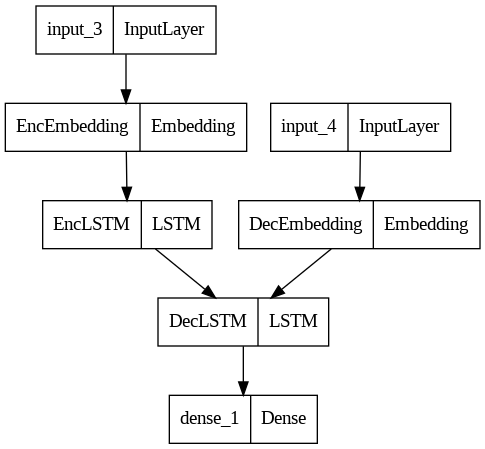

In [31]:
plot_model(model)

In [32]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 3, verbose = 1, restore_best_weights=True)

In [33]:
history = model.fit(X_train,y_train,
                    batch_size=32,
                    epochs=20,
                    validation_split=0.10,
                    validation_batch_size=32,
                    callbacks=[checkpoint,earlystopping])

Epoch 1/20
2386/2391 [============================>.] - ETA: 0s - loss: 1.1069
Epoch 1: val_loss improved from inf to 0.54585, saving model to model.h5
2391/2391 [==============================] - 35s 12ms/step - loss: 1.1057 - val_loss: 0.5459
Epoch 2/20
  11/2391 [..............................] - ETA: 24s - loss: 0.5682

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2391/2391 [==============================] - ETA: 0s - loss: 0.4544
Epoch 2: val_loss improved from 0.54585 to 0.40655, saving model to model.h5
2391/2391 [==============================] - 24s 10ms/step - loss: 0.4544 - val_loss: 0.4066
Epoch 3/20
2386/2391 [============================>.] - ETA: 0s - loss: 0.3509
Epoch 3: val_loss improved from 0.40655 to 0.35605, saving model to model.h5
2391/2391 [==============================] - 24s 10ms/step - loss: 0.3510 - val_loss: 0.3560
Epoch 4/20
2391/2391 [==============================] - ETA: 0s - loss: 0.2953
Epoch 4: val_loss improved from 0.35605 to 0.33625, saving model to model.h5
2391/2391 [==============================] - 23s 10ms/step - loss: 0.2953 - val_loss: 0.3362
Epoch 5/20
2386/2391 [============================>.] - ETA: 0s - loss: 0.2566
Epoch 5: val_loss improved from 0.33625 to 0.32843, saving model to model.h5
2391/2391 [==============================] - 24s 10ms/step - loss: 0.2566 - val_loss: 0.3284
Epoch 6/20
2388

In [34]:
# model.save('w2p.h5')

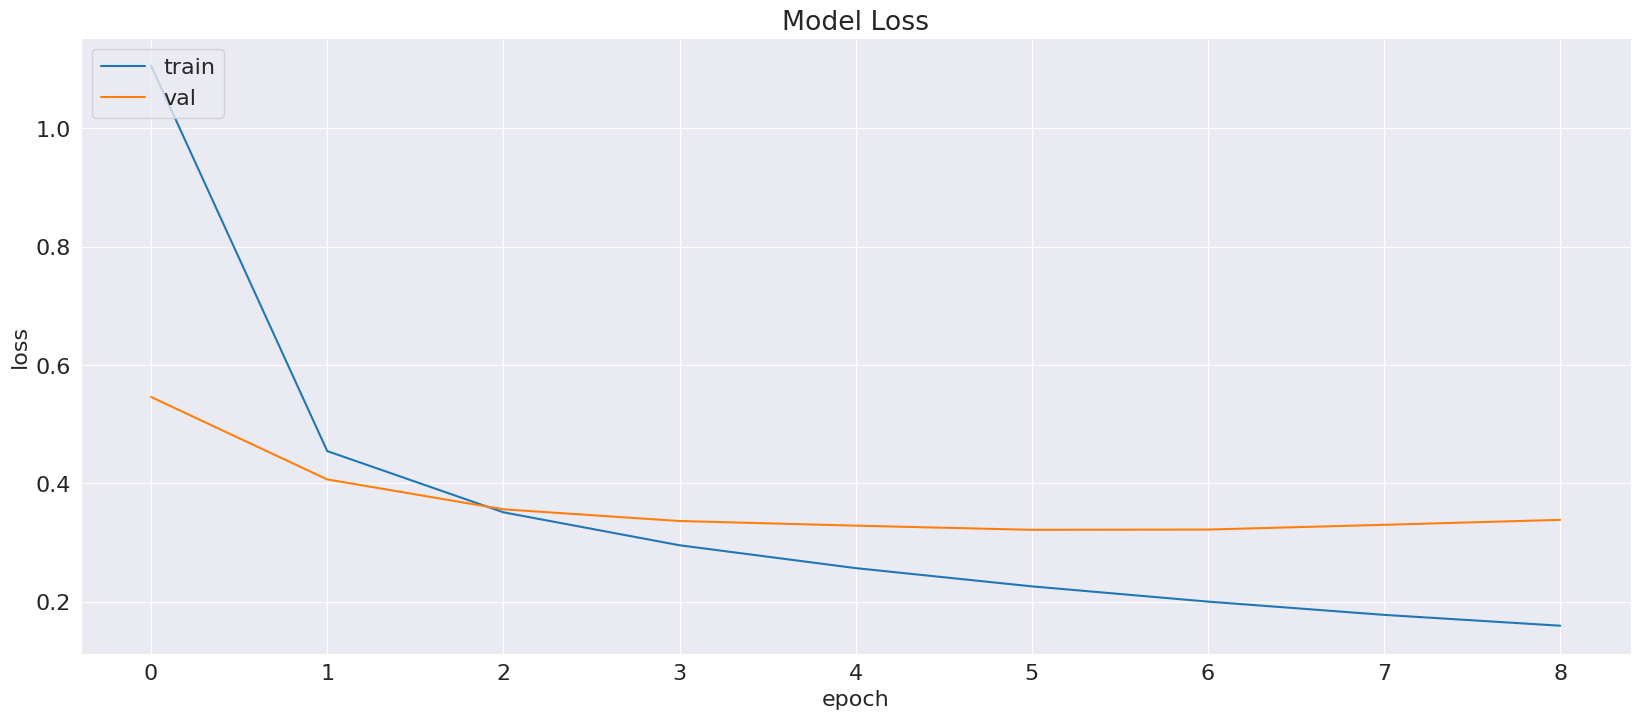

In [35]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [36]:
encoder = Model(char_input, [state_h, state_c])

#Decoder
decoder_input_h = Input(shape=(256,))
decoder_input_c = Input(shape=(256,))
x = embedding_layer(ph_input)
x, decoder_output_h, decoder_output_c = decoder_lstm(x, initial_state=[decoder_input_h, decoder_input_c])
x = softmax_dense(x)
decoder = Model([ph_input] + [decoder_input_h, decoder_input_c],
                                [x] + [decoder_output_h, decoder_output_c])

In [37]:
def predict_pronunciation(ch_input):
    input_seq = char_tokenizer.texts_to_sequences([ch_input])

    next_h, next_c = encoder.predict(input_seq, verbose=0)

    curr_token = np.zeros((1, 1))
    curr_token[0, 0] = phone_tokenizer.word_index['startseq']

    pred_sentence = ''

    for i in range(max_len_op):
        output, next_h, next_c = decoder.predict([curr_token] + [next_h, next_c], verbose=0)
        next_token = np.argmax(output[0, 0, :])
        next_word = phone_tokenizer.index_word[next_token]
        if next_word == 'endseq':
            break
        else:
            pred_sentence += ' ' + next_word
            curr_token[0, 0] = next_token

    return pred_sentence

In [38]:
words = ['helds','cardholder','siddhant','shardul','laughed','salamance','christopher',
         'avanish','garchomp','absol','gliscor','isha','sesquepedalian','crying',
         'backstabbing','harsh','avantika','strong','originate']

for word in words:
    phoneme = predict_pronunciation(word)
    print(f"Word: {word}, Phoneme: {phoneme}\n")


Word: helds, Phoneme:  hh eh1 l d z

Word: cardholder, Phoneme:  k aa1 r d hh ow2 l d er0

Word: siddhant, Phoneme:  s ih1 d hh aa0 n t

Word: shardul, Phoneme:  sh aa0 r d ah1 l

Word: laughed, Phoneme:  l ao1 f t

Word: salamance, Phoneme:  s ae1 l ah0 m ah0 n s

Word: christopher, Phoneme:  k r ih1 s t ah0 f er0

Word: avanish, Phoneme:  ah0 v ae1 n ih0 sh

Word: garchomp, Phoneme:  g aa1 r k hh aa2 m p

Word: absol, Phoneme:  ae1 b s ah0 l

Word: gliscor, Phoneme:  g l ih1 s k er0

Word: isha, Phoneme:  ih1 sh ah0

Word: sesquepedalian, Phoneme:  s eh2 k s w iy2 p eh1 d ah0 l iy2 n

Word: crying, Phoneme:  k r ay1 ih0 ng

Word: backstabbing, Phoneme:  b ae1 k s t b ae2 ng

Word: harsh, Phoneme:  hh aa1 r sh

Word: avantika, Phoneme:  ah0 v ae2 n t iy1 k ah0

Word: strong, Phoneme:  s t r ao1 ng

Word: originate, Phoneme:  er0 ih1 jh ah0 n ey2 t



# Speech To Phoneme

In [39]:
dataset = load_dataset("mozilla-foundation/common_voice_11_0", "en", split="test", streaming = True)

In [40]:
dataset_head = dataset.take(500)

In [41]:
num_examples = 0
num_columns = None

for example in dataset_head:
    num_examples += 1
    if num_columns is None:
        num_columns = len(example.keys())

# Print the shape
print("Number of Examples:", num_examples)
print("Number of Columns:", num_columns)

Reading metadata...: 16354it [00:02, 6008.71it/s]


Number of Examples: 500
Number of Columns: 11


In [42]:
feature_names = dataset_head.features.keys()
feature_names

dict_keys(['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'])

### Separating Audio and Sentence from the Dataset

In [43]:
audio_data = []
sentence_data = []

# Iterate through the dataset and extract the 'audio' and 'sentence' columns
for example in dataset_head:
    if 'audio' in example and 'sentence' in example:
        audio_data.append(example['audio'])
        sentence_data.append(example['sentence'])

Reading metadata...: 16354it [00:02, 6342.22it/s]


### Predicting the `phonemes` for each sentence

In [46]:
predicted_phonemes = []

def predict_pronunciation_for_sentence(sentence):
    # Tokenize the sentence into words
    words = sentence.split()

    # Predict phonemes for each word in the sentence
    predicted_phonemes_for_sentence = [predict_pronunciation(word) for word in words]

    # Combine the predicted phonemes into a sentence
    predicted_sentence = ' '.join(predicted_phonemes_for_sentence)

    return predicted_sentence

# Iterate through the dataset and generate phoneme sequences for each sentence
for sentence in sentence_data:
    predicted_sentence = predict_pronunciation_for_sentence(sentence)
    predicted_phonemes.append(predicted_sentence)


### Mapping the column of `predicted_phonemes` to their sentences in the dataset

In [47]:
name = "predicted_phonemes"

predicted_phonemes = ['startseq ' + s + ' endseq' for s in predicted_phonemes]

new_features = dataset_head.features.copy()
new_features[name] = new_features["sentence"]

def add_column_fn_1(example, idx):
    if name in example:
        raise ValueError(f"Error when adding {name}: column {name} is already in the dataset.")
    return {name: predicted_phonemes[idx]}

data = dataset_head.map(add_column_fn_1, with_indices=True, features=new_features)

In [48]:
feature_names = data.features.keys()
feature_names

dict_keys(['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'predicted_phonemes'])

In [49]:
# Convert the iterable dataset to a list of dictionaries
data_list = list(data)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data_list)

# Optionally, you can set the column names to the feature_names
df.columns = feature_names

Reading metadata...: 16354it [00:00, 42287.02it/s]


In [50]:
# Separate the 'audio' column into three separate columns: 'path', 'array', and 'sr'
df['array'] = df['audio'].apply(lambda x: x['array'])
df['sr'] = df['audio'].apply(lambda x: x['sampling_rate'])

# Drop the original 'audio' column if you no longer need it
df = df.drop(columns=['audio'])

columns_to_keep = ['path', 'array', 'sr', 'sentence', 'predicted_phonemes']
df = df[columns_to_keep]


In [51]:
df.head()

,path,array,sr,sentence,predicted_phonemes
0,en_test_0/common_voice_en_27710027.mp3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,"Joe Keaton disapproved of films, and Buster al...",startseq jh ow1 k iy1 t ah0 n d ih0 s ah0 p...
1,en_test_0/common_voice_en_699711.mp3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,She'll be all right.,startseq sh eh1 l b iy1 ao1 l r ay1 t endseq
2,en_test_0/common_voice_en_21953345.mp3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,six,startseq s ih1 k s endseq
3,en_test_0/common_voice_en_18132047.mp3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,All's well that ends well.,startseq ao1 l z w eh1 l th ae1 t eh1 n d ...
4,en_test_0/common_voice_en_27340672.mp3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,It is a busy market town that serves a large s...,startseq ih1 t ih1 z ey1 b y uw1 z iy0 m ...


You can see that all the columns needed are there

In [52]:
def create_mfcc_features(x, sr):
    mfccs = []
    try:
        mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=128)
        mfccs = np.mean(mfccs.T,axis=0)
    except:
        print('Error reading audio')
    return mfccs


In [53]:
mfcc_features = {}

for index, row in df.iterrows():
    audio_data = row['array']
    audio_sr = row['sr']
    audio_path = row['path']

    try:
        mfcc_features[audio_path] = create_mfcc_features(audio_data, audio_sr)
    except Exception as e:
        print(f'Error processing audio file {audio_path}: {str(e)}')


In [54]:
sentences = df['predicted_phonemes'].values


In [55]:
sentences[:5]

array(['startseq  jh ow1  k iy1 t ah0 n  d ih0 s ah0 p r uw1 v d  ow1 f  f ih1 l m s  ae1 n d  b ah1 s t er0  ae1 l s ow0  hh ae1 d  r eh2 z er0 v ey1 sh ah0 n z  ah0 b aw1 t  dh  m iy1 d iy0 ah0 m endseq',
       'startseq  sh eh1 l  b iy1  ao1 l  r ay1 t endseq',
       'startseq  s ih1 k s endseq',
       'startseq  ao1 l z  w eh1 l  th ae1 t  eh1 n d z  w eh1 l endseq',
       'startseq  ih1 t  ih1 z  ey1  b y uw1 z iy0  m aa1 r k ih0 t  t aw1 n  th ae1 t  s er1 v z  ey1  l aa1 r jh  s er0 aw1 n d ih0 ng  eh1 r iy0 ah0 endseq'],
      dtype=object)

In [56]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(sentences)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in sentences)

In [57]:
print(f"Vocabulary Size: {vocab_size}")
print(f"Maximum Sequence Length: {max_length}")

Vocabulary Size: 71
Maximum Sequence Length: 89


In [58]:
def get_model_input(df):

    X_feature, X_seq, y = list(), list(), list()
    audio_files = df['path'].tolist()

    for audio_file in audio_files:
        # Extract MFCC features and reshape them
        feature = mfcc_features[audio_file].reshape(16, 8, 1)

        # Extract predicted phoneme sequences for the current audio file
        captions = df.loc[df['path'] == audio_file, 'predicted_phonemes'].tolist()

        # Iterate through the predicted phoneme sequences
        for caption in captions:
            # Convert the phoneme sequence to numerical tokens
            sequence = tokenizer.texts_to_sequences([caption])[0]

            # Iterate through the phoneme sequence tokens
            for i in range(1, len(sequence)):
                # Split the sequence into input and output segments
                in_sequence, out_sequence = sequence[:i], sequence[i]

                # Pad the input sequence to a consistent length
                in_sequence = tf.keras.preprocessing.sequence.pad_sequences([in_sequence], maxlen=max_length)[0]

                # Convert the output sequence to one-hot encoded format
                out_sequence = tf.keras.utils.to_categorical([out_sequence], num_classes=vocab_size)[0]

                # Append data to respective lists
                X_feature.append(feature)  # MFCC features
                X_seq.append(in_sequence)  # Input sequence
                y.append(out_sequence)     # Target output sequence

    # Convert lists to NumPy arrays for model training
    X_feature, X_seq, y = np.array(X_feature), np.array(X_seq), np.array(y)

    # Return the prepared data
    return X_feature, X_seq, y


In [59]:
train, test = train_test_split(df, test_size=0.2)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

train.shape, test.shape

((400, 5), (100, 5))

In [60]:
train_feature, train_seq, train_y = get_model_input(train)
test_feature, test_seq, test_y = get_model_input(test)

train_feature.shape, train_seq.shape, train_y.shape

((14958, 16, 8, 1), (14958, 89), (14958, 71))

In [61]:
input_model_1 = Input(shape=(16, 8, 1)) #speech
feature_model = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding = "same")(input_model_1)
feature_model = MaxPooling2D(2, 2)(feature_model)
feature_model = Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding = "same")(feature_model)
feature_model = MaxPooling2D(2, 2)(feature_model)
feature_model = Flatten()(feature_model)
feature_model = Dense(256, activation='relu')(feature_model)

# LSTM  model
input_model_2 = Input(shape=(max_length,)) #phonemes
seq_model = Embedding(vocab_size, 128, mask_zero=True)(input_model_2)
seq_model = Dropout(0.5)(seq_model)
seq_model = LSTM(256, activation='relu')(seq_model)

# Merging both models
decoder = add([feature_model, seq_model])
decoder = Dense(256, activation='relu')(decoder)
output_model = Dense(vocab_size, activation='softmax')(decoder)

# [image, seq] [word]
model = Model(inputs=[input_model_1, input_model_2], outputs=output_model)
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))



In [62]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 16, 8, 1)]           0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 8, 16)            160       ['input_7[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 8, 4, 16)             0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 4, 8)              1160      ['max_pooling2d[0][0]'] 

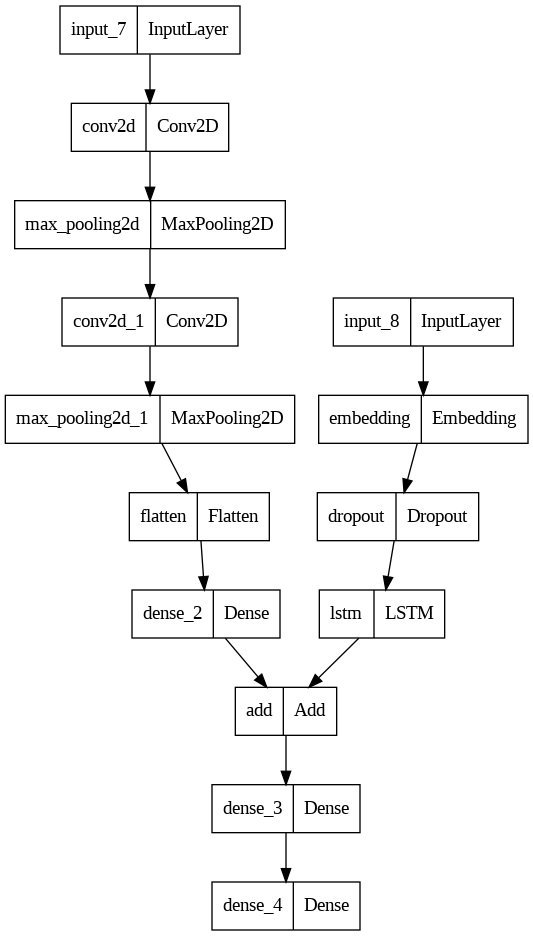

In [63]:
plot_model(model)

In [64]:
model_name = "phoneme_model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.00000001)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

In [66]:
history = model.fit((train_feature, train_seq), train_y, epochs=100,
                    validation_data=((test_feature, test_seq), test_y), callbacks=[checkpoint, earlystopping, reduce_lr])

Epoch 1/100
468/468 [==============================] - ETA: 0s - loss: 2.7974
Epoch 1: val_loss improved from 3.18955 to 3.17443, saving model to phoneme_model.h5
468/468 [==============================] - 76s 162ms/step - loss: 2.7974 - val_loss: 3.1744 - lr: 0.0010
Epoch 2/100
468/468 [==============================] - ETA: 0s - loss: 2.7551
Epoch 2: val_loss did not improve from 3.17443
468/468 [==============================] - 76s 161ms/step - loss: 2.7551 - val_loss: 3.1908 - lr: 0.0010
Epoch 3/100
468/468 [==============================] - ETA: 0s - loss: 2.7214
Epoch 3: val_loss did not improve from 3.17443
468/468 [==============================] - 75s 160ms/step - loss: 2.7214 - val_loss: 3.1987 - lr: 0.0010
Epoch 4/100
468/468 [==============================] - ETA: 0s - loss: 2.6801
Epoch 4: val_loss did not improve from 3.17443
468/468 [==============================] - 76s 162ms/step - loss: 2.6801 - val_loss: 3.1896 - lr: 0.0010
Epoch 5/100
468/468 [=====================

In [67]:
# model.save('s2p.h5')

In [68]:
def inverse_tokenizer(index):
    for word, i in tokenizer.word_index.items(): #what is the index of our word in the dataset
        if i==index:
            return word
    return None

In [69]:
def speech_to_text(audio_path):
    # path = audio_path.split('/')[-1]
    feature = mfcc_features[audio_path].reshape(-1, 16, 8, 1) #make mfcc and reshape
    pred_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([pred_text])[0]#converting text to sequence
        sequence = tf.keras.preprocessing.sequence.pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence]) #prediction
        y_pred = np.argmax(y_pred)
        word = inverse_tokenizer(y_pred)
        if word is None:
            break
        pred_text+= " " + word
        if word == 'endseq':
            break
    return pred_text

In [70]:
sample_df = test.sample(1)
files = sample_df['path'].tolist()
actual_transcription = sample_df['predicted_phonemes'].tolist()
pred_transcription = []
for file in files:
    transcription = speech_to_text(file)
    pred_transcription.append(transcription)

1/1 [==============================] - 0s 32ms/step


In [71]:
sample_df['sentence']

48    Cador is also said to be of Roman stock.
Name: sentence, dtype: object

In [72]:
pred_transcription

['startseq dh k ae1 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0']

# Phoneme To Word

In [73]:
words = []
phonics_list = []
dict_file = open('/content/cmudict.dict', 'r')
with dict_file as f:
    phonics = [line.rstrip('\n') for line in f]
    for p in phonics:
        x = p.split(' ')
        words.append(x[0])
        phonics_list.append(' '.join(x[1:]))
ptw = pd.DataFrame({'Word': words, 'Phonics': phonics_list})
ptw.head()

,Word,Phonics
0,'bout,B AW1 T
1,'cause,K AH0 Z
2,'course,K AO1 R S
3,'cuse,K Y UW1 Z
4,'em,AH0 M


In [74]:
ptw = ptw.sample(100000).reset_index(drop=True)
ptw

,Word,Phonics
0,samara,S AE1 M ER0 AH0
1,lawbreakers,L AO1 B R EY2 K ER0 Z
2,petroglyph,P EH1 T R OW0 G L IH2 F
3,stalwarts,S T AO1 L W ER0 T S
4,hilfiger,HH IH1 L F AY0 G ER0
...,...,...
99995,sturgeon(2),S T ER1 JH IH0 N
99996,clues,K L UW1 Z
99997,frigate's,F R IH1 G AH0 T S
99998,townsman,T AW1 N Z M AH0 N


In [75]:
ptw[~ptw['Word'].apply(lambda x: x.isalnum())]

,Word,Phonics
9,p.s,P IY1 Z
23,pervert(2),P ER0 V ER1 T
33,defazio(2),D IH0 F EY1 Z IY0 OW0
65,kirk's,K ER1 K S
68,monica's,M AA1 N IH0 K AH0 Z
...,...,...
99981,fuel(2),F Y UW1 L
99989,resigning(2),R IY0 Z AY1 N IH0 NG
99995,sturgeon(2),S T ER1 JH IH0 N
99997,frigate's,F R IH1 G AH0 T S


In [76]:
ptw['Word'] = 'startseq ' + ptw['Word']+ ' endseq'
ptw.head()

,Word,Phonics
0,startseq samara endseq,S AE1 M ER0 AH0
1,startseq lawbreakers endseq,L AO1 B R EY2 K ER0 Z
2,startseq petroglyph endseq,P EH1 T R OW0 G L IH2 F
3,startseq stalwarts endseq,S T AO1 L W ER0 T S
4,startseq hilfiger endseq,HH IH1 L F AY0 G ER0


In [77]:
max_len_op = ptw['Word'].apply(lambda x: len(x)).max()
max_len_ip = ptw['Phonics'].apply(lambda x: len(x.split())).max()

In [78]:
words = ptw['Word'].tolist()
phonemes = ptw['Phonics'].tolist()

In [79]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(words)
word_vocab_size = len(word_tokenizer.word_index) + 1
print("Word Vocab Size: ",word_vocab_size)

Word Vocab Size:  94327


In [80]:
phone_tokenizer = Tokenizer(oov_token='OOV')
phone_tokenizer.fit_on_texts(phonemes)
phone_vocab_size = len(phone_tokenizer.word_index) + 1
print("Phoneme Vocab Size: ",phone_vocab_size)

Phoneme Vocab Size:  76


In [81]:
wd_sequences = word_tokenizer.texts_to_sequences(words)
ph_sequences = phone_tokenizer.texts_to_sequences(phonemes)

In [82]:
print("Word: ", words[3])
print("Word Sequence: ",wd_sequences[3])

Word:  startseq stalwarts endseq
Word Sequence:  [1, 5459, 2]


In [83]:
encoder_inputs = pad_sequences(ph_sequences, maxlen=max_len_ip, padding='post')

In [84]:
decoder_inputs = []
decoder_outputs = []

In [85]:
for wd in wd_sequences:
    decoder_inputs.append(wd[:-1])
    decoder_outputs.append(wd[1:])

In [86]:
decoder_inputs = pad_sequences(decoder_inputs, maxlen=max_len_op, padding='post')
decoder_outputs = pad_sequences(decoder_outputs, maxlen=max_len_op, padding='post')

In [87]:
n = len(phonemes)
split_index = int(0.85 * n)

In [88]:
X_train = [encoder_inputs[:split_index], decoder_inputs[:split_index]]
y_train = decoder_outputs[:split_index]

In [89]:
X_test = phonemes[split_index:]
y_test = words[split_index:]

In [90]:
ph_vocab = 76

In [91]:
# Encoder
ph_input = Input(shape=(None,))
x = Embedding(ph_vocab, 256, mask_zero=True)(ph_input)
output_y, state_h, state_c = LSTM(256, return_state=True)(x)

In [92]:
# Decoder
wd_input = Input(shape=(None,))
embedding_layer = Embedding(word_vocab_size, 256, mask_zero=True)
x = embedding_layer(wd_input)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
output_y, _ , _ = decoder_lstm(x, initial_state=[state_h, state_c])
intermediate_dense = Dense(256, activation='relu')(output_y)
softmax_dense = Dense(word_vocab_size, activation='softmax')
output = softmax_dense(intermediate_dense)

In [93]:
model = Model(inputs=[ph_input, wd_input],outputs=output)
model.compile(loss='sparse_categorical_crossentropy',optimizer= tf.keras.optimizers.Adam(learning_rate=0.001))
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, None, 256)            19456     ['input_9[0][0]']             
                                                                                                  
 embedding_2 (Embedding)     (None, None, 256)            2414771   ['input_10[0][0]']            
                                                          2                                 

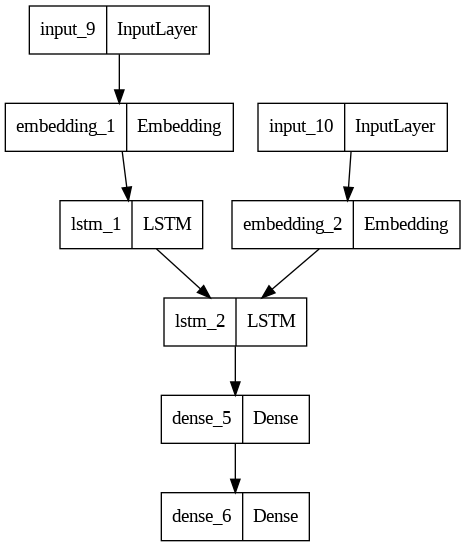

In [94]:
plot_model(model)

In [95]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 3, verbose = 1, restore_best_weights=True)

In [96]:
history = model.fit(X_train,y_train,
                    batch_size=32,
                    epochs=10,
                    validation_split=0.10,
                    validation_batch_size=32,
                    callbacks=[checkpoint,earlystopping])

Epoch 1/10
2391/2391 [==============================] - ETA: 0s - loss: 5.8661
Epoch 1: val_loss improved from inf to 5.96861, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2391/2391 [==============================] - 242s 98ms/step - loss: 5.8661 - val_loss: 5.9686
Epoch 2/10
2391/2391 [==============================] - ETA: 0s - loss: 5.6150
Epoch 2: val_loss did not improve from 5.96861
2391/2391 [==============================] - 227s 95ms/step - loss: 5.6150 - val_loss: 6.4733
Epoch 3/10
2391/2391 [==============================] - ETA: 0s - loss: 5.3916
Epoch 3: val_loss did not improve from 5.96861
2391/2391 [==============================] - 226s 95ms/step - loss: 5.3916 - val_loss: 6.9197
Epoch 4/10
2391/2391 [==============================] - ETA: 0s - loss: 4.9612
Epoch 4: val_loss did not improve from 5.96861
Restoring model weights from the end of the best epoch: 1.
2391/2391 [==============================] - 226s 95ms/step - loss: 4.9612 - val_loss: 7.5999
Epoch 4: early stopping


In [97]:
# model.save('p2w.h5')

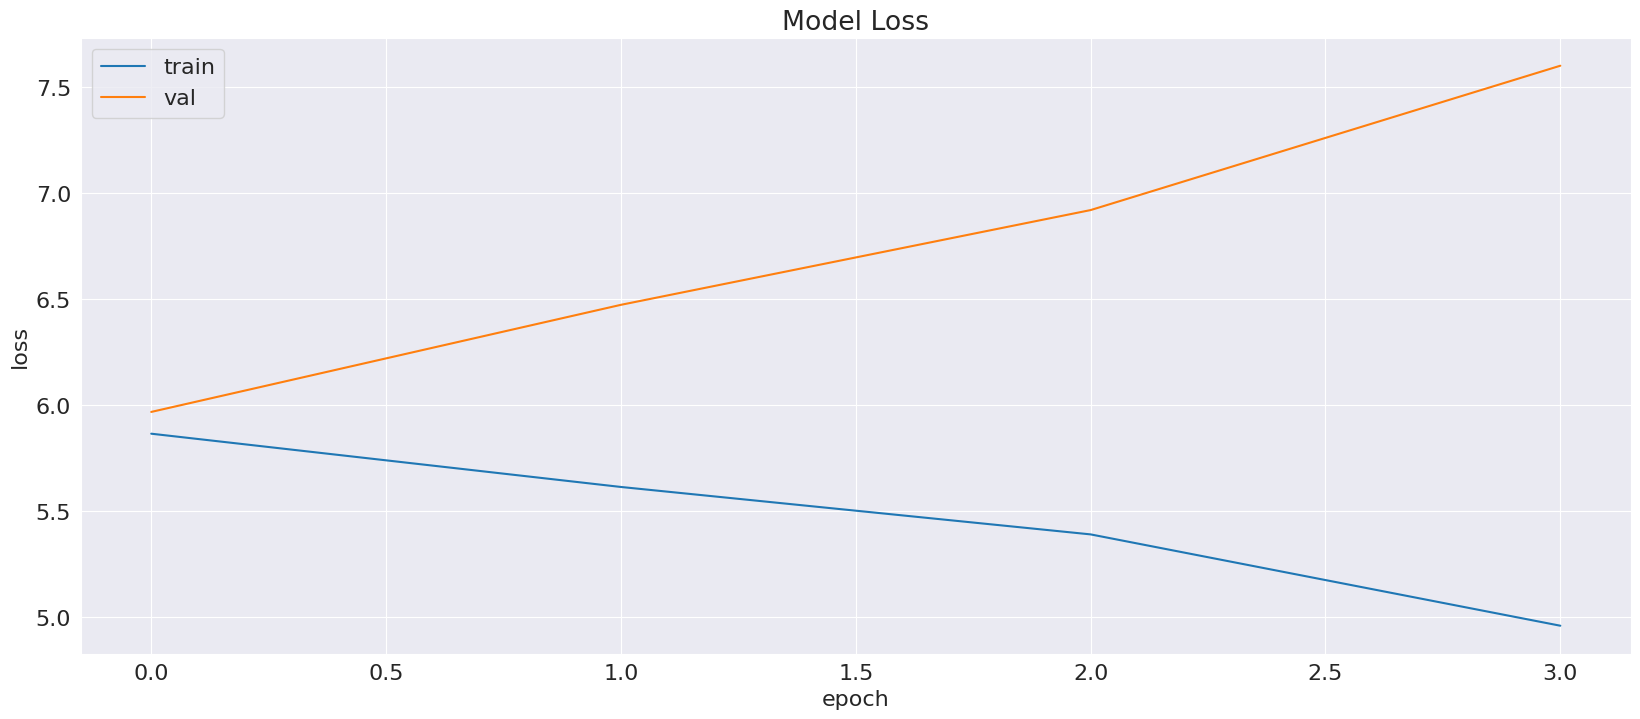

In [98]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [99]:
encoder = Model(ph_input, [state_h, state_c])

#Decoder
wd_input = Input(shape=(None,))
decoder_input_h = Input(shape=(256,))
decoder_input_c = Input(shape=(256,))
x = embedding_layer(wd_input)
x, decoder_output_h, decoder_output_c = decoder_lstm(x, initial_state=[decoder_input_h, decoder_input_c])
x = softmax_dense(x)
decoder = Model([wd_input] + [decoder_input_h, decoder_input_c],
                                [x] + [decoder_output_h, decoder_output_c])
decoder.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, None, 256)            2414771   ['input_11[0][0]']            
                                                          2                                       
                                                                                                  
 input_12 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 input_13 (InputLayer)       [(None, 256)]                0         []                      

In [100]:
def predict_word(wd_input):
    input_seq = phone_tokenizer.texts_to_sequences([wd_input])

    next_h, next_c = encoder.predict(input_seq, verbose=0)
    curr_token = np.zeros((1, 1))
    curr_token[0, 0] = word_tokenizer.word_index['startseq']

    pred_sentence = ''

    for i in range(max_len_op):
        output, next_h, next_c = decoder.predict([curr_token] + [next_h, next_c], verbose=0)
        next_token = np.argmax(output[0, 0, :])
        next_word = word_tokenizer.index_word[next_token]
        if next_word == 'endseq':
            break
        else:
          pred_sentence += ' ' + next_word
          curr_token[0, 0] = next_token

    return pred_sentence

In [101]:
for sentence in pred_transcription:
    phoneme = predict_word(sentence)
    print(f"Phoneme: {sentence} \n Sentence: {phoneme}\n")


Phoneme: startseq dh k ae1 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 l ah0 
 Sentence:  shortages non non non non non non non non non self ickes yogiisms runaround yogiisms archdiocese right life right yogiisms archdiocese pint am pint am pint am pint shortages pint shortages pint shortages pint shortages pint shortages pint shortages



this is a niche and developing field where advancements are still being made as models are not able to capture the semantics